# <span style="color:red">Analyze A/B Test Results<span>
    
## Headlines: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)

Each task are arranged with a **ToDo** tag, which we ask a question and try to answer it.

<a id='intro'></a>
## <span style="color:#04AEC4">Introduction<span>

In this notebook, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through lots of processes to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## <span style="color:#04AEC4">Part I - Probability<spand>

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42) # We set the seed to 42

### ToDo 1.1
The `ab_data.csv` is our data. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Reading the dataset from the `ab_data.csv` file:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** The number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
df['converted'].sum() / df['user_id'].nunique()

0.12126269856564711

The `treatment` group should have the `new_page` in the **landing_page**. And the opposite ofcource. But there may be some values that are not like that so we need to check.

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page != "old_page"').shape[0]

3893

It seems that there are some of those values indedd.

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

Great, there is no missing values.

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Handling the rows where the group and landing_page columns don't match to make the dataframe meet the specifications.

In [8]:
# Removing the inaccurate rows, and storing the result in a new dataframe df2
treatment_and_new = df.query('group == "treatment" and landing_page != "new_page"')
control_and_old = df.query('group == "control" and landing_page != "old_page"')

df2 = df.drop(treatment_and_new.index)
df2 = df2.drop(control_and_old.index)

In [9]:
# Double Checking all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Awesome!

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** Accordingly from the number of rows, it seems that there is one **user_id** repeated in **df2**.  What is it?

In [11]:
c = df2['user_id']
c[c.duplicated()]

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**

In [12]:
duplicate = df2[df2.duplicated('user_id')]
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(duplicate.index)
# Check again if the row with a duplicate user_id is deleted or not
df2.shape

(290584, 5)

#### Cleaning is now done 👌
Now the dataset is ready for analysis.

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?

In [14]:
p_population = df2['converted'].mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2[df2['group'] == 'control']['converted'].mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2[df2['group'] == 'treatment']['converted'].mean()
p_treatment

0.11880806551510564

>The probabilities we computed in the points (b). and (c). above can also be treated as conversion rate. 
Now we will calculate the actual difference (`obs_diff`) between the conversion rates for the two groups. We will need that later.  

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [18]:
df2[df2['landing_page'] == 'new_page'].count()[0] / df2.shape[0]

0.50006194422266881

**Considering the results form parts (a) through (d) above.** We saw that nearly half of the individuals have recived the `new_page`, and the other half are still in the `old_page`, so there is a fair comparison here.<br>
And the probablilty of people who `converted` in the treatment group is less than the control group.<br>
With that being said, we can say that the `treatment` group **doesn't** lead to more conversions.

<a id='ab_test'></a>
## <span style="color:#04AEC4">Part II - A/B Test<span>

### ToDo 2.1
we need to make the decision just based on all the data provided.  

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then our null and alternative hypotheses (**$H_0$** and **$H_1$**) should be:
$$H_0: p_{new} \leq p_{old}$$


$$H_1: p_{new} \gt p_{old}$$
> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = df['converted'].mean()
p_new

0.11965919355605512

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old = df['converted'].mean()
p_old

0.11965919355605512

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2['landing_page'] == 'new_page'].count()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['landing_page'] == 'old_page'].count()[0]
n_old

145274

**e. Simulating Sample for the `treatment` Group**<br> 
We will Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.

In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1 - p_new])

**f. Simulating Sample for the `control` Group** <br>
Then, we will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1 - p_old])

**g.** The difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
new_page_converted.mean() - old_page_converted.mean()

8.7345074909206399e-05


**h. Sampling distribution** <br>
We will re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

In [26]:
# Sampling distribution 
new_page_converted = np.random.binomial(n_new, p_new, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_page_converted - old_page_converted

**i. Histogram**<br> 
Ploting a histogram of the **p_diffs**.

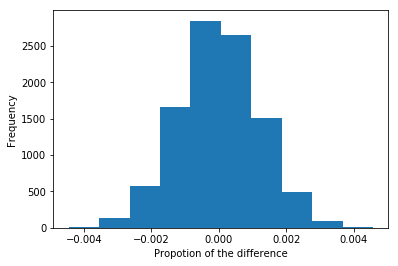

In [27]:
plt.hist(p_diffs)
plt.xlabel('Propotion of the difference')
plt.ylabel('Frequency');

It looks normaly distributed, just as expected.

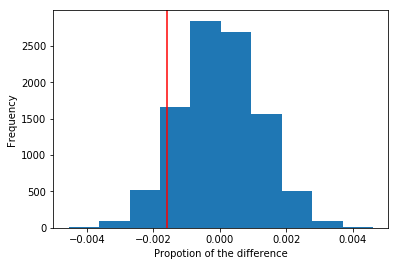

In [28]:
# Ploting the nul_vals against the obs_diff
nul_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(nul_vals)
plt.axvline(x=obs_diff, color='r')
plt.xlabel('Propotion of the difference')
plt.ylabel('Frequency');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
(nul_vals > obs_diff).mean()

0.90800000000000003

**k.** This value that we just computed is caled `p-value`<br>
Sine the `p-value` is greater than the type I error rate `alpha` **$\alpha$** (0.05), so we fail to reject the null hypothesis.<br>
In other words, the `p_new` and `p_old` are equal.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results and to double check.

In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').count()[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now using `sm.stats.proportions_ztest()` to compute the test statistic and p-value.

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

In [31]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** **As we saw in the findings in parts j. and k.**. The $Z_{score}$ is less than the $Z_{\alpha}$. And the the `p_value` looks nearly <br> the same for ours that we estimated earlier.<br>
With that being said, we have confirmed that we fail to reject the null hypothesis.<br>
So, The conversion rates of the old and new pages are equal.

<a id='regression'></a>
## <span style="color:#04AEC4">Part III - A regression approach<span>

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br>

**a.** Since each row in the `df2` data is either a conversion or no conversion, so the type of regression should we be performing in this case is the **Logistic Regression**

**b.** The goal is to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:

In [32]:
df2['intercept'] = 1
df2[['old_page', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop(['old_page', 'group'], axis=1)

In [33]:
df2.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0


**c.** Instantiating the regression model on the two columns we created in part (b). above, then fitting the model to predict whether or not an individual converts. 

In [34]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Next, providing the summary of our model below, and using it as necessary to answer some needed questions.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-19 09:37 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** Ok, so our p-value here is **0.1899**.<br>
But this value due to our regression model is based on the hypothesis we made to it. That is, if the `ab_page` is a good factor to determine if a person will convert to the new page (the alternitive) or not (the null hypothesis), and the p-vale we saw earlier is from the hypothesis if the convertion rate in the new_page is equal to the old_page (the null hypothesis) or not (the alternitive).<br>
And since the p-value here is more than the type I error rate (0.05), so we fail to reject the null hypothesis.That is, the `ab_page` is not a good factor to determine if a person will convert or not.

**f.** So because the the `ab_page` is not a good mesure, we need to put into considerition that we need other factors to determine if a person will convert to the new_page or not and to make the model fits really good. But the data we will collect to add to our model, must be choosing carefully so that they must be interconnected in determinig if a person will convert or not so that it will not be misleading.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also we well add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [36]:
# Reading the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

We see that the contries of the users are only these there '{**UK**', '**US**', '**CS**'}.

In [38]:
# Joining with the df2 dataframe
df_merged = df2.join(countries_df.set_index('user_id'), on='user_id')

In [39]:
df_merged.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,US


In [40]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop(['CA', 'country'], axis=1)
df_merged.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,0,1


We will be also adding a new two columns, which are the interaction between the `ab_page` and the two countreis (**UK**, **US**).

In [41]:
# Adding a new two columns to help fitting the model well
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged.head()

,user_id,timestamp,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,old_page,0,1,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,old_page,0,1,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,1,0,0,1,0,0


Now, we are ready to fit our model.

**h. Fit your model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.

In [42]:
# Fitting the model, and summarizing the results
logit_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-02-19 09:37 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

So the p-values for UK, US, UK_ab_page and US_ab_page are **0.7674**, **0.6418**, **0.1681** and **0.3833** respectively, and the ab_page is also bigger than the type I error rate.<br>
Which are all greater than the type I error rate (0.05).<br>
Which means that they can not be a factor to determine if a person will convert or not (we failed to rejedt the null hypothesis).

In [43]:
np.exp(0.0118), np.exp(0.0175)

(1.011869894648401, 1.0176540221507617)

But regardless of the p-values, we can say that:<br>

- the person is more likely to convert to the new page by a factor of (1.011) if he is from **UK**
- the person is more likely to convert to the new page by a factor of (1.017) if he is from **US**

<a id = "conclusion"></a>
## <span style="color:purple">Conclusion!</span>
Based on what we have seen throw this notebook and the entire processes we have made, from probabilites to hypothesis testing, and ending with a regression approach,<br>
It is better to maintain the old page because the new page didn't work out as expected to attract more people to it.

---

In [44]:
# Just creating a .html version of this notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0